# Homework 4 - Cross-validation
**Estimated completion time: 1.5-2.5 hours (including write-up)**

**Goal:** Use **cross-validation** to choose the best **multiple logistic regression** model from model variants. We will be using the same dataset as Week 3; our modeling goal is to predict **`status`** (`0 = alive`, `1 = deceased`) from predictors in the [**ISLP Brain Cancer**](https://islp.readthedocs.io/en/latest/datasets/BrainCancer.html) dataset.

**Workflow:**
In this assignment you will walk through the **complete predictive modeling workflow** for a **multiple logistic regression model**: from splitting the data into train/test/validation, to **model assessment** and **model selection**. This is also an example for the minimum I expect from one person in your group projects.

**What you will do:**

1. **Split** dataset into **train** and **test** sets (hold the test set until the end).
2. Using **only the training set**, create train/validation splits with **each approach** (use `sklearn.model_selection.cross_validate`):
   - Validation set approach (**random 50/50** train/validation splits)
   - **Leave‑One‑Out** Cross‑Validation (LOOCV)
   - **10‑Fold** Cross‑Validation
3. **Fit** a multiple logistic regression model on the training folds and **predict held‑out outcomes** on validation folds.
4. **Compute validation error** (average classification error) for each approach in (2).
5. **Model selection**: Repeat steps 3-4 for several **variations** of the logistic regression model (use different subsets of the predictors)
6. **Plot** average classification error vs. **number of parameters** in the logistic regression model for **each approach in (2)** → **three (3) plots** total.
7. **Report the best model** using your chosen cross‑validation method, and **summarize findings**.

> **Comments marked **# YOUR CODE HERE** must be completed for the code to run

> **Please also make sure you are pasting your plots and answering any questions in the document in the **main homework document**, not in this notebook.

## 0) Setup (imports)
If running locally and something is missing, install `ISLP`, `statsmodels`, and `scikit-learn`.

In [15]:
# Imports\
!pip install -q ISLP statsmodels scikit-learn pandas numpy matplotlib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import (
    train_test_split, ShuffleSplit, LeaveOneOut, StratifiedKFold, cross_validate
)
from sklearn.metrics import accuracy_score
from sklearn.neighbors import KNeighborsClassifier

RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

# Load dataset (BrainCancer from ISLP, or use df already in memory if provided earlier in the notebook)
from ISLP import load_data
df = load_data('BrainCancer')

# Define predictors & outcome (update if your notebook defined them already)
predictors_all = ['sex','diagnosis','loc','ki','gtv']
outcome = 'status'

# Clean: drop rows with missing outcome or predictors
data = df.dropna(subset=[outcome] + predictors_all).copy()
data[outcome] = data[outcome].astype(int)

# Identify numeric vs categorical predictors
num_cols_all = [c for c in predictors_all if pd.api.types.is_numeric_dtype(data[c])]
cat_cols_all = [c for c in predictors_all if not pd.api.types.is_numeric_dtype(data[c])]


print('Data shape after cleaning:', data.shape)
print('Numeric:', num_cols_all, '| Categorical:', cat_cols_all)


Data shape after cleaning: (87, 8)
Numeric: ['ki', 'gtv'] | Categorical: ['sex', 'diagnosis', 'loc']


## 0) Define our model

**We define:**
- **Outcome:** `status` (0 = alive, 1 = deceased)
- **Predictors (quantitative):** `ki`, `gtv`
- **Predictors (qualitative):**`sex`, `diagnosis`, `loc`

Let $p= P(\text{status} = 1 \mid \text{sex}, \text{diagnosis}, \text{loc}, \text{ki}, \text{gtv})$

**Then our logistic regression model is:**
$\log\left(\frac{p}{1 - p}\right)
= \beta_0 + \beta_1 \text{ki} + \beta_2\text{gtv} + \beta_3\text{Male[Yes]} + \beta_4 \text{LGglioma[Yes]} + \beta_5\text{Meningioma[Yes]} + \beta_6  \text{OtherDiag[Yes]} + \beta_7 \text{Supratentorial[Yes]}$

where $[\text{Yes}]=1$ if the variable is that factor, and $0$ if not.

The **baseline factors** are:
*  `Female` for `sex`
*  `HG glioma` for `diagnosis`
*  `Infratentorial` for `loc`


## 0) Helper function: pipeline
`make_pipeline()` builds a workflow (called a pipeline) for logistic regression that:
* Preprocesses the input features correctly (numeric and categorical handled separately), and
* Fits a logistic regression model to the processed data.

This ensures there’s no data leakage and all model fitting steps are applied consistently each time.


In [16]:

def make_pipeline(num_cols, cat_cols):
    pre = ColumnTransformer(
        transformers=[
            ('num', StandardScaler(), num_cols),
            ('cat', OneHotEncoder(drop='first', handle_unknown='ignore'), cat_cols),
        ]
    )
    # fit logistic regression model
    clf = LogisticRegression(max_iter=5000, solver='lbfgs', random_state=RANDOM_STATE)
    return Pipeline([('pre', pre), ('clf', clf)])


## 1) Train/Test Split (hold‑out test for the very end)

Use `train_test_split(..., stratify=...)` with stratification on `status`. Split the data into **80% train set** and **20% test set**. Use `stratify=data['status']` to ensure there's same proportion of `status = 0s/1s` in both splits as in the full data.


In [17]:
X = data[predictors_all]
y = data[outcome].astype(int)

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    stratify=data['status'],
)

train_df = X_train.copy()
train_df[outcome] = y_train

test_df = X_test.copy()
test_df[outcome] = y_test
y_train = train_df[outcome].astype(int) # train set that can be further split into train / validation sets
y_test  = test_df[outcome].astype(int) # don't touch until very end

print('Train size:', train_df.shape, '| Test size:', test_df.shape)
train_df.head()

Train size: (69, 6) | Test size: (18, 6)


,sex,diagnosis,loc,ki,gtv,status
74,Male,Other,Supratentorial,100,24.91,0
37,Male,HG glioma,Supratentorial,90,9.95,1
8,Female,Meningioma,Supratentorial,70,12.16,0
27,Male,HG glioma,Supratentorial,70,33.69,1
79,Female,Meningioma,Infratentorial,70,2.94,0



## 1) Example demonstration on one data point: fit on training split and evaluate on a single 50/50 validation split
Use `ShuffleSplit` to perform a **single** random validation split to illustrate “train → predict validation” before we switch to `cross_validate` for all methods.


In [18]:
# Choose a subset of predictors for the demo
predictors_demo = ['sex','diagnosis','loc','ki','gtv']
num_cols = [c for c in predictors_demo if c in num_cols_all]
cat_cols = [c for c in predictors_demo if c in cat_cols_all]

X_train_all = train_df[predictors_demo]
pipeline = make_pipeline(num_cols, cat_cols)

# One 50/50 validation split
ss = ShuffleSplit(n_splits=1, test_size=0.5)
(tr_idx, va_idx), = ss.split(X_train_all, y_train)

X_tr = X_train_all.iloc[tr_idx]; y_tr = y_train.iloc[tr_idx]
X_va = X_train_all.iloc[va_idx]; y_va = y_train.iloc[va_idx]

pipeline.fit(X_tr, y_tr)
pred_va = pipeline.predict(X_va)
acc = accuracy_score(y_va, pred_va)
val_error_single = 1.0 - acc
print(f'Validation error (single 50/50 split): {val_error_single:.3f}')


Validation error (single 50/50 split): 0.314



## 2-4) Validation error with each approach using `cross_validate`
Use `cross_validate` to obtain mean validation set accuracy (and convert into mean validation error = 1-accuracy) for these methods:
- Validation set approach (50/50 random splits) (Hint: use `ShuffleSplit`)
- LOOCV (Hint: use `LeaveOneOut`)
- 10‑fold CV (Hint: use `StratifiedKFold`)


In [19]:
results_cv = {}

predictors = ['sex','diagnosis','loc','ki','gtv']
num_cols = [c for c in predictors if c in num_cols_all]
cat_cols = [c for c in predictors if c in cat_cols_all]
pipeline = make_pipeline(num_cols, cat_cols) # fit model
X = train_df[predictors]

# Validation set approach
cv_function = ShuffleSplit(n_splits=1, test_size=0.5)
acc =  cross_validate(pipeline, X, y_train, cv=cv_function, scoring='accuracy')
mean_acc = np.mean(acc['test_score']);
err = 1.0 - mean_acc;
results_cv['valid_set'] = {'val_error': err, 'val_accuracy': mean_acc}

# LOOCV
# YOUR CODE HERE
cv_function = LeaveOneOut()
acc = cross_validate(pipeline, X, y_train, cv = cv_function, scoring = "accuracy")
mean_acc = np.mean(acc["test_score"])
err = 1.0 - mean_acc
results_cv['LOOCV'] = {'val_error': err, 'val_accuracy': mean_acc}

# 10-fold CV
# YOUR CODE HERE
cv_function = StratifiedKFold(n_splits = 10)
acc = cross_validate(pipeline, X, y_train, cv = cv_function, scoring = "accuracy")
mean_acc = np.mean(acc["test_score"])
results_cv['10foldCV'] = {'val_error': err, 'val_accuracy': mean_acc}

pd.DataFrame(results_cv).T # print error / accuracy table


,val_error,val_accuracy
valid_set,0.342857,0.657143
LOOCV,0.304348,0.695652
10foldCV,0.304348,0.714286



## 5-6) Model selection and plots: average classification error vs number of parameters (three approaches)
For each of the three approaches in Step 2, plot the **mean validation error** against the number of parameters for a sequence of models of increasing size.


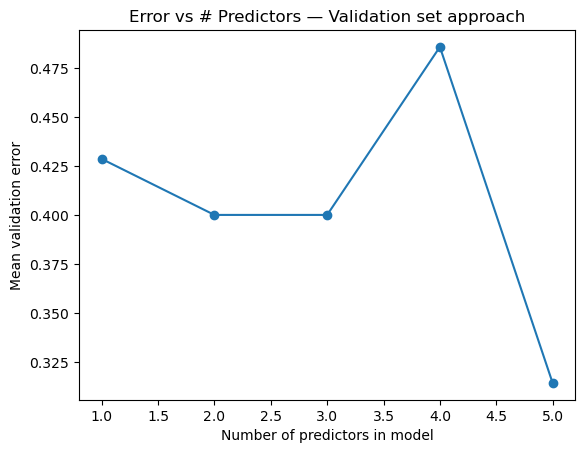

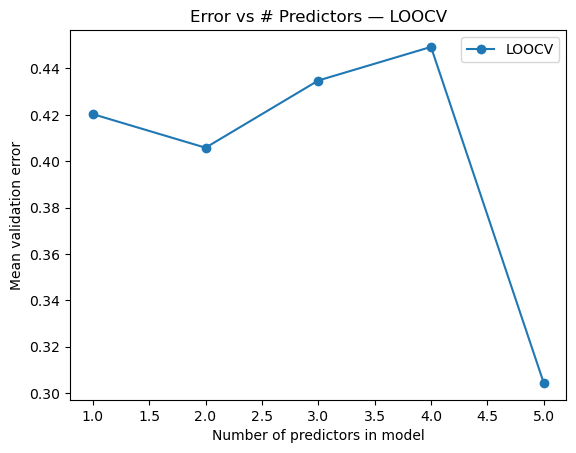

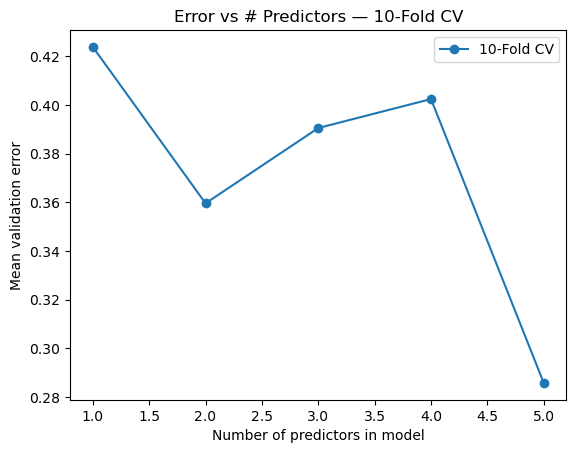

In [20]:

# Define model variations using subsets of the # of predictors
# Experiment with your own variations to find the one with the lowest validation error.

# example variations (you should try out other combos of predictors)
model_variations = [
    ['ki'],
    ['ki','gtv'],
    ['ki','gtv','sex'],
    ['ki','gtv','sex','loc'],
    ['ki','gtv','sex','loc','diagnosis'],
]
results = {'valid_set': [], 'LOOCV': [], '10foldCV': []}

for predictors in model_variations:
  num_cols = [c for c in predictors if c in num_cols_all]
  cat_cols = [c for c in predictors if c in cat_cols_all]
  pipeline = make_pipeline(num_cols, cat_cols)
  X = train_df[predictors]
  # YOUR CODE HERE
  
  # validation 
  cv_function = ShuffleSplit(n_splits=1, test_size=0.5)
  acc = cross_validate(pipeline, X, y_train, cv=cv_function, scoring='accuracy')
  mean_acc = np.mean(acc['test_score'])
  results['valid_set'].append(1.0 - mean_acc)  
  
  # LOOCV
  cv_function = LeaveOneOut()
  acc = cross_validate(pipeline, X, y_train, cv=cv_function, scoring='accuracy')
  mean_acc = np.mean(acc['test_score'])
  results['LOOCV'].append(1.0 - mean_acc)  
  
  # 10-fold CV
  cv_function = StratifiedKFold(n_splits=10)
  acc = cross_validate(pipeline, X, y_train, cv=cv_function, scoring='accuracy')
  mean_acc = np.mean(acc['test_score'])
  results['10foldCV'].append(1.0 - mean_acc) 

num_predictors = [len(p) for p in model_variations]
# Plot for validation set approach
plt.figure()
plt.plot(num_predictors, results['valid_set'], marker = 'o', label = "Validation Set")
plt.xlabel('Number of predictors in model')
plt.ylabel('Mean validation error')
plt.title(f'Error vs # Predictors — Validation set approach')
plt.show()

# Plot for LOOCV
# YOUR CODE HERE
plt.figure()
plt.plot(num_predictors, results['LOOCV'], marker='o', label='LOOCV')
plt.xlabel('Number of predictors in model')
plt.ylabel('Mean validation error')
plt.title('Error vs # Predictors — LOOCV')
plt.legend()
plt.show()

# Plot for 10-fold CV
# YOUR CODE HERE
plt.figure()
plt.plot(num_predictors, results['10foldCV'], marker='o', label='10-Fold CV')
plt.xlabel('Number of predictors in model')
plt.ylabel('Mean validation error')
plt.title('Error vs # Predictors — 10-Fold CV')
plt.legend()
plt.show()


## 7) Report: Best model (by your chosen method) & summary
See questions in the Homework PDF

In [32]:

# Evaluate best model on TEST set
best_predictors = best_model[0]
num_cols = [c for c in best_predictors if c in num_cols_all]
cat_cols = [c for c in best_predictors if c in cat_cols_all]
final_model = make_pipeline(num_cols, cat_cols)

# Fit on full training set
final_model.fit(X_train[best_predictors], y_train)

# Test error
yhat_test = final_model.predict(X_test[best_predictors])
test_error = 1.0 - accuracy_score(y_test, yhat_test)

# Naive baseline
baseline_error = 1-y_test.value_counts(normalize=True).max()

print("Naive baseline error rate:", round(baseline_error, 3))
print(f'Best model test error = {test_error:.3f}')

Naive baseline error rate: 0.389
Best model test error = 0.389



## ★ For the advanced and curious...try out cross‑validation on a different model!

Pick **one** alternative classifier and evaluate it with the **same** resampling method and preprocessing pipeline:

- **k‑Nearest Neighbors (KNN)** — `KNeighborsClassifier(n_neighbors=...)`  
- **Linear Discriminant Analysis (LDA)** — `LinearDiscriminantAnalysis()`  
- **Quadratic Discriminant Analysis (QDA)** — `QuadraticDiscriminantAnalysis()`  


Best model: ['diagnosis']
Number of predictors: 1
Validation error (10-Fold CV): 0.2714



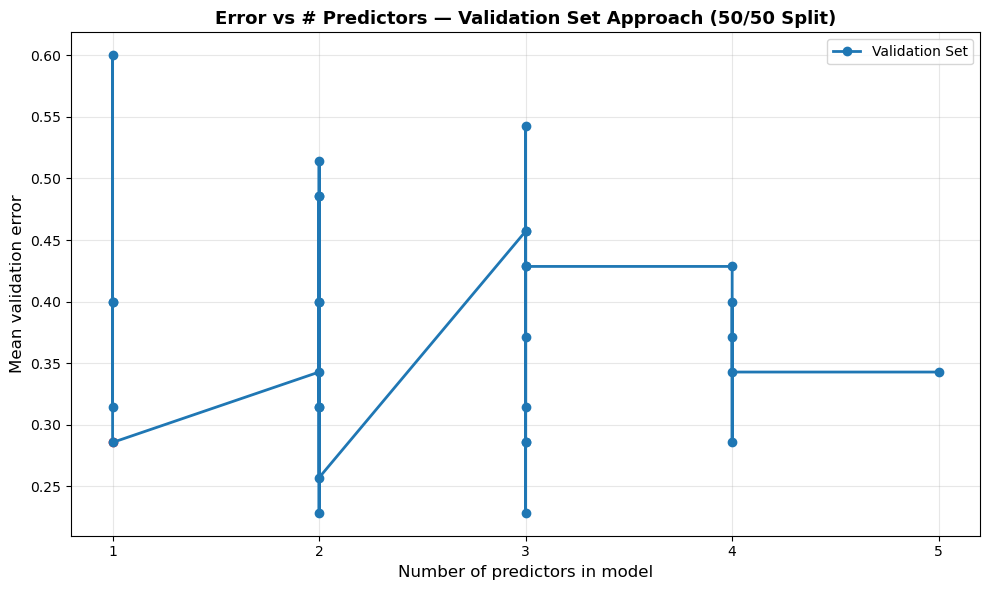

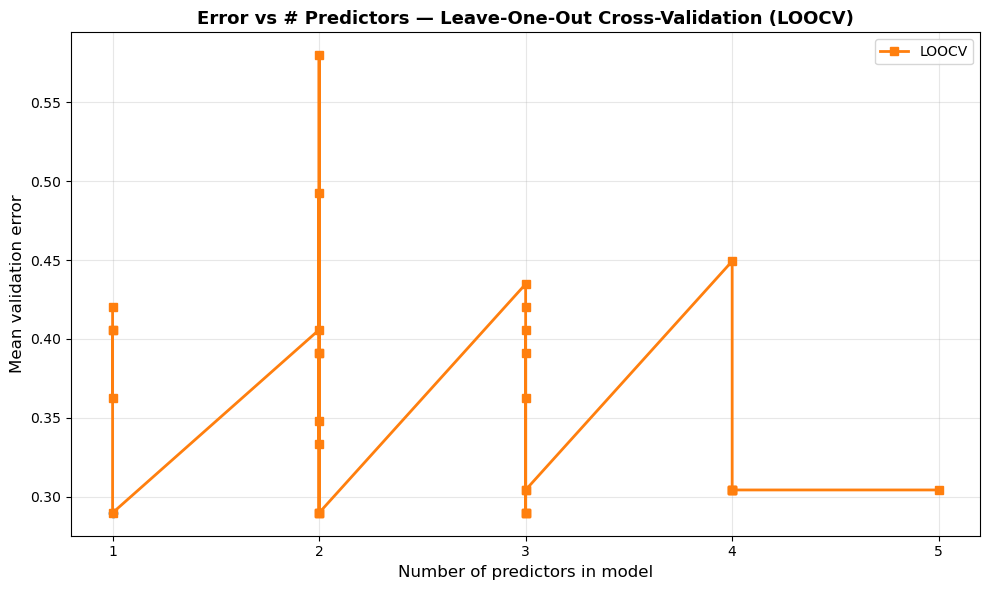

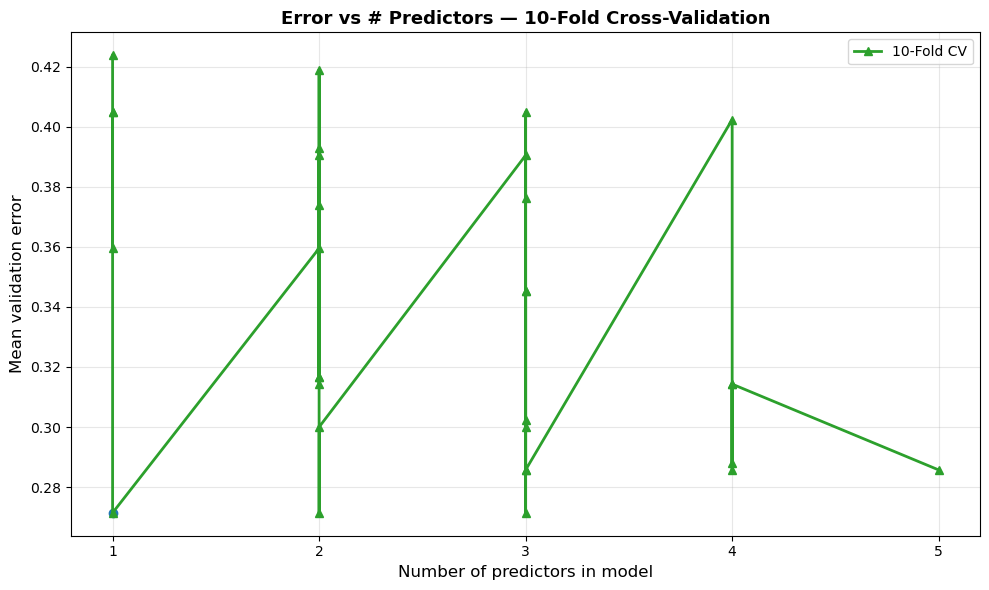

BEST MODEL SUMMARY
Best Predictors: ['diagnosis']
Number of Predictors: 1
Validation Error (10-Fold CV): 0.2714


In [35]:
## Uses AI to learn how to generate the 3 models 

from itertools import combinations

all_predictors = ['ki', 'gtv', 'sex', 'loc', 'diagnosis']
results = {'valid_set': [], 'LOOCV': [], '10foldCV': []}
model_variations = []
validation_errors_all = []

for r in range(1, len(all_predictors) + 1):
    for subset in combinations(all_predictors, r):
        model_variations.append(list(subset))
        num_cols = [c for c in subset if c in num_cols_all]
        cat_cols = [c for c in subset if c in cat_cols_all]
        pipeline = make_pipeline(num_cols, cat_cols)
        X = train_df[list(subset)]
        
        cv_function = ShuffleSplit(n_splits=1, test_size=0.5, random_state=RANDOM_STATE)
        acc = cross_validate(pipeline, X, y_train, cv=cv_function, scoring='accuracy')
        mean_acc = np.mean(acc['test_score'])
        results['valid_set'].append(1.0 - mean_acc)
        
        cv_function = LeaveOneOut()
        acc = cross_validate(pipeline, X, y_train, cv=cv_function, scoring='accuracy')
        mean_acc = np.mean(acc['test_score'])
        results['LOOCV'].append(1.0 - mean_acc)
        
        cv_function = StratifiedKFold(n_splits=10, shuffle=False)
        acc = cross_validate(pipeline, X, y_train, cv=cv_function, scoring='accuracy')
        mean_acc = np.mean(acc['test_score'])
        results['10foldCV'].append(1.0 - mean_acc)
        
        validation_errors_all.append((list(subset), 1.0 - mean_acc))

best_model = min(validation_errors_all, key=lambda x: x[1])
print(f"Best model: {best_model[0]}")
print(f"Number of predictors: {len(best_model[0])}")
print(f"Validation error (10-Fold CV): {best_model[1]:.4f}")
print()

num_predictors = [len(p) for p in model_variations]

plt.figure(figsize=(10, 6))
plt.plot(num_predictors, results['valid_set'], marker='o', linestyle='-', linewidth=2, markersize=6, label='Validation Set', color='#1f77b4')
plt.scatter([len(best_model[0])], [results['valid_set'][model_variations.index(best_model[0])]], 
            color='red')
plt.xlabel('Number of predictors in model', fontsize=12)
plt.ylabel('Mean validation error', fontsize=12)
plt.title('Error vs # Predictors — Validation Set Approach (50/50 Split)', fontsize=13, fontweight='bold')
plt.grid(True, alpha=0.3)
plt.legend(fontsize=10)
plt.xticks(range(1, 6))
plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 6))
plt.plot(num_predictors, results['LOOCV'], marker='s', linestyle='-', linewidth=2, markersize=6, label='LOOCV', color='#ff7f0e')
plt.scatter([len(best_model[0])], [results['LOOCV'][model_variations.index(best_model[0])]])
plt.xlabel('Number of predictors in model', fontsize=12)
plt.ylabel('Mean validation error', fontsize=12)
plt.title('Error vs # Predictors — Leave-One-Out Cross-Validation (LOOCV)', fontsize=13, fontweight='bold')
plt.grid(True, alpha=0.3)
plt.legend(fontsize=10)
plt.xticks(range(1, 6))
plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 6))
plt.plot(num_predictors, results['10foldCV'], marker='^', linestyle='-', linewidth=2, markersize=6, label='10-Fold CV', color='#2ca02c')
plt.scatter([len(best_model[0])], [results['10foldCV'][model_variations.index(best_model[0])]])
plt.xlabel('Number of predictors in model', fontsize=12)
plt.ylabel('Mean validation error', fontsize=12)
plt.title('Error vs # Predictors — 10-Fold Cross-Validation', fontsize=13, fontweight='bold')
plt.grid(True, alpha=0.3)
plt.legend(fontsize=10)
plt.xticks(range(1, 6))
plt.tight_layout()
plt.show()


print("BEST MODEL SUMMARY")
print(f"Best Predictors: {best_model[0]}")
print(f"Number of Predictors: {len(best_model[0])}")
print(f"Validation Error (10-Fold CV): {best_model[1]:.4f}")
